# Figure 2 — Set size effects, Stimulus prioritization

In [1]:
include("src/model.jl")
include("src/fig_setsize_and_prioritization.jl");

In [2]:
Ks = [2, 4, 8];

## 1. Data (Bays 2014, Experiment 2) 

In [3]:
using MATLAB, DataFramesMeta

In [4]:
data = read_matfile("../data/Bays14/Exp2_data.mat")
data = Dict(k => jarray(v) for (k, v) in data);

In [5]:
cols = ["subject", "valid", "n_items", "error"]
data = Dict(k => vec(v) for (k, v) in data if k in cols)

# make dataframe
df_exp = DataFrame(data)
df_exp.valid = Bool.(df_exp.valid);

In [6]:
errors_exp_cued   = Dict()
errors_exp_uncued = Dict()
subjects = unique(df_exp.subject)

for K in Ks
    df = @subset(df_exp, :n_items .== K)
    
    df_cued   = @subset(df, :valid .== true)
    df_uncued = @subset(df, :valid .== false)    
    
    errors_exp_cued[K]   = [gdf.error for gdf in groupby(df_cued, :subject)]
    errors_exp_uncued[K] = [gdf.error for gdf in groupby(df_uncued, :subject)]
end

## 2. Simulation

In [7]:
# load existing run
using FileIO
errors_sim_cued   = load("data/fig2.jld2", "errors_sim_cued")
errors_sim_uncued = load("data/fig2.jld2", "errors_sim_uncued");

In [104]:
# optimal weighting factor for cued stimulus
αopt = Dict(
    2 => 1.5,
    4 => 2.2,
    8 => 3.0
)

nneurons = 1000

nsubjects = 10
nsamples = 1000

errors_sim_cued   = Dict(K => [Float64[] for s in 1:nsubjects] for K in Ks)
errors_sim_uncued = Dict(K => [Float64[] for s in 1:nsubjects] for K in Ks)

# set experiment structure
sim = nothing
timing = TimingCondition("fig2", 1000, 3000)

# run experiment
for K in Ks
    lg("K = $K")
    
    # create simulation for given population size
    sim = Simulation(div(nneurons, K), 8, K)
    
    # set higher probing probability for cued stimulus (always pop 1 here)
    α = ones(K); α[1] = αopt[K]
    πprobe = α ./ sum(α)
    
    for subject in 1:nsubjects
        # reset simulation
        reset!(sim, seed=SEEDS[subject])

        # build seq
        cue = rand(sim.rng, 1:sim.nstimuli)
        seq = getseq(sim, timing, cue; repeat=2)
        
        # run simulation
        run!(sim, seq, πprobe=πprobe)

        # sample reconstruction error
        samples = samplesim(sim, N=nsamples)

        # get error for cued stimulus
        errors_sim_cued[K][subject] = cdist.(samples[:,1], sim.stimuli[cue])

        # get error for uncued stimulus
        probed = rand(sim.rng, 2:K)
        errors_sim_uncued[K][subject] = cdist.(samples[:,probed], sim.stimuli[cue])
    end
end

[2022-02-25T17:16:05.449] K = 2
[2022-02-25T17:20:08.353] K = 4
[2022-02-25T17:23:51.673] K = 8


In [122]:
# save errors to file
#using FileIO
#save("data/fig2.jld2", "errors_sim_cued", errors_sim_cued, "errors_sim_uncued", errors_sim_uncued)

## 3. Final figure

In [8]:
errors_exp = Dict(k => vcat(errors_exp_cued[k], errors_exp_uncued[k]) for k in Ks)
errors_sim = Dict(k => vcat(errors_sim_cued[k], errors_sim_uncued[k]) for k in Ks);

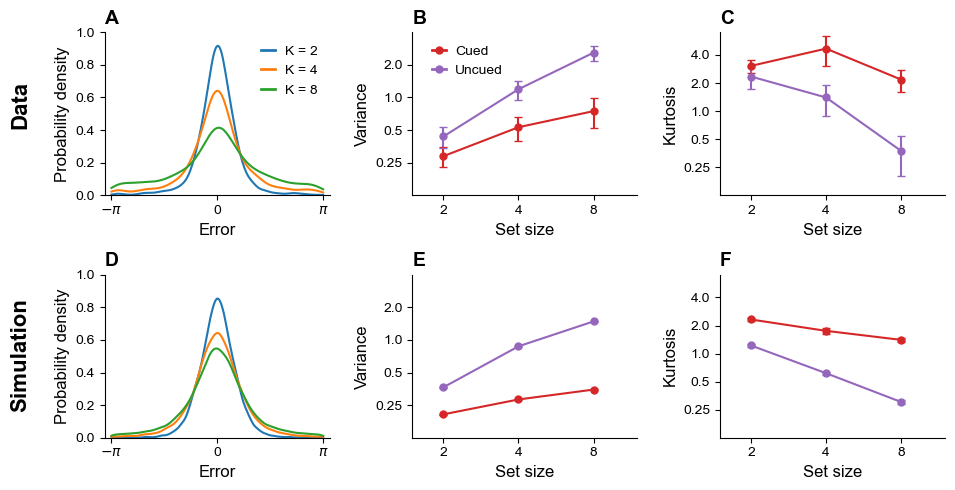

In [15]:
fig = figure("fig2_setsize_and_prioritization", figsize=(10, 5))

# A: error density
ax = subplot(231)
plt.title("A")
plot_setsize!(ax, errors_exp)
legend() |> legend_shorten_lines!

# B: variance
ax = subplot(232)
plt.title("B")
plot_prioritization!(ax, errors_exp_cued, errors_exp_uncued; fun=cvar)
ax.set_ylabel("Variance")

handles, labels = ax.get_legend_handles_labels()
# filter out any line other than the "main" horizontal line
handles = [h[1] for h in handles]
leg = ax.legend(handles, labels)
legend_shorten_lines!(leg)


# C: kurtosis
ax = subplot(233)
plt.title("C")
plot_prioritization!(ax, errors_exp_cued, errors_exp_uncued; fun=ckurtosis)
ax.set_ylabel("Kurtosis")

ax.set_ylim(0.125, 7)
ax.set_yticks([0.25, 0.5, 1, 2, 4])
ax.set_yticklabels([0.25, 0.5, 1, 2, 4])


# D: error density
ax = subplot(234)
plt.title("D")
plot_setsize!(ax, errors_sim)

# E: variance
ax = subplot(235)
plt.title("E")
plot_prioritization!(ax, errors_sim_cued, errors_sim_uncued; fun=cvar)
ax.set_ylabel("Variance")

# F: kurtosis
ax = subplot(236)
plt.title("F")
plot_prioritization!(ax, errors_sim_cued, errors_sim_uncued; fun=ckurtosis)
ax.set_ylabel("Kurtosis")

ax.set_ylim(0.125, 7)
ax.set_yticks([0.25, 0.5, 1, 2, 4])
ax.set_yticklabels([0.25, 0.5, 1, 2, 4])

# Update the figure
fig.tight_layout(w_pad=1.8, rect=(0.04, 0, 0.96, 1)) # (left, bottom, right, top)

# add Data and Simulation annotations
annotate_data_simulation_side!();

In [16]:
fig.savefig("figs/fig2_setsize_and_prioritization.pdf", bbox_inches="tight")